Gradient Domain Fusion

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg
from scipy.sparse.linalg import spsolve


# modify to where you store your project data including utils.py
datadir = "/Users/isaac/OneDrive/Desktop/UIUC/CS445/Project 3/cs445_proj3_starter_code/cs445_proj3_starter_code/" 

utilfn = datadir + "utils.py"
!copy "$utilfn" .
samplesfn = datadir + "samples"
!copy -r "$samplesfn" .
import utils

The file cannot be copied onto itself.
        0 file(s) copied.
The system cannot find the file specified.


## Part 1 Toy Problem (20 pts)

In [3]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """

    # TO DO
    height, width = img.shape
    pix_idx = np.arange(height * width).reshape(height, width)

    eq_count = height * (width - 1) + (height - 1) * width + 1
    mat_A = np.zeros((eq_count, height * width))
    vec_b = np.zeros(eq_count)

    eq = 0
    for y in range(height):
        for x in range(width - 1):
            mat_A[eq, pix_idx[y, x+1]] = 1
            mat_A[eq, pix_idx[y, x]] = -1
            vec_b[eq] = img[y, x+1] - img[y, x]
            eq += 1

    for y in range(height - 1):
        for x in range(width):
            mat_A[eq, pix_idx[y+1, x]] = 1
            mat_A[eq, pix_idx[y, x]] = -1
            vec_b[eq] = img[y+1, x] - img[y, x]
            eq += 1

    mat_A[eq, pix_idx[0, 0]] = 1
    vec_b[eq] = img[0, 0]

    mat_A = scipy.sparse.csr_matrix(mat_A)
    solution = scipy.sparse.linalg.lsqr(mat_A, vec_b, atol=1e-14, btol=1e-14)

    return solution[0].reshape((height, width))

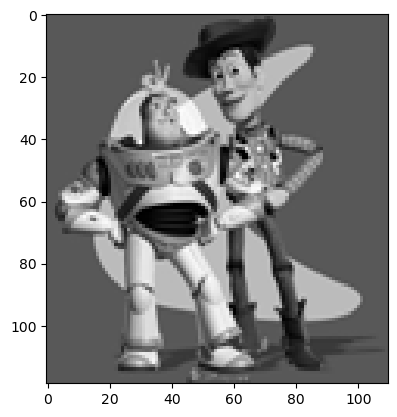

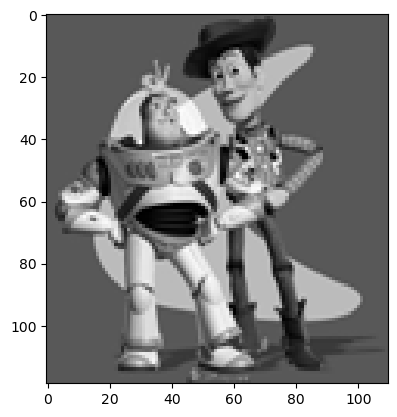

Max error is:  7.420841718897009e-12


In [4]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

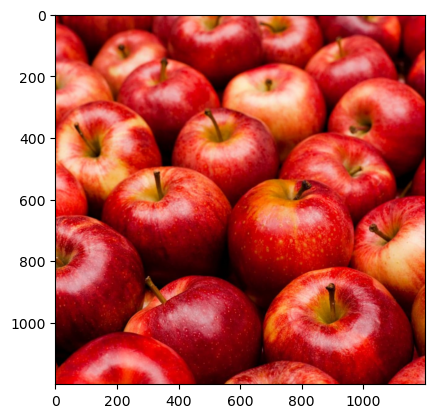

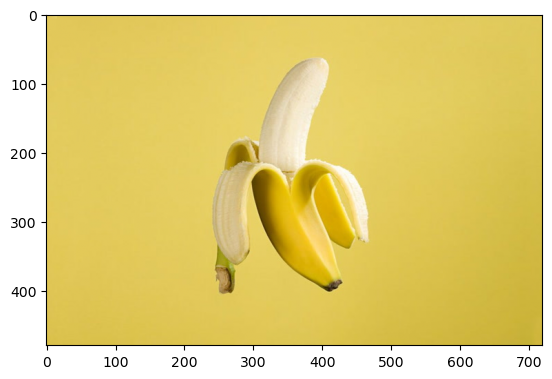

In [5]:
background_img = cv2.cvtColor(cv2.imread('samples/apples.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()

object_img = cv2.cvtColor(cv2.imread('samples/banana.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_img = object_img

#new_width = 300
#new_height = 150  # You can set your desired height and width values here

# Resize the image
#object_img = cv2.resize(object_img, (new_width, new_height), interpolation=cv2.INTER_AREA)
#object_img = object_img.resize((500,800))

plt.imshow(object_img)
plt.show()
#print(object_img)

use_interface = True  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
    xs = (300, 1000, 1000, 300)
    ys = (500, 500, 50, 50)
    object_mask = utils.get_mask(ys, xs, object_img)
    bottom_center = (2300,2900) # (x,y)
    #xs = (65, 359, 359, 65)
    #ys = (24, 24, 457, 457)
    #object_mask = utils.get_mask(ys, xs, object_img)
    #bottom_center = (500, 2500) # (x,y)

    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
    


In [9]:
if use_interface:
    import matplotlib.pyplot as plt
    %matplotlib notebook
    mask_coords = utils.specify_mask(object_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>

In [7]:
if use_interface:
    xs = mask_coords[0]
    ys = mask_coords[1]
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure()
    object_mask = utils.get_mask(ys, xs, object_img)

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 640x480 with 0 Axes>

In [ ]:
if use_interface:
    %matplotlib notebook
    import matplotlib.pyplot as plt
    bottom_center = utils.specify_bottom_center(background_img)

    

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>

In [ ]:
    %matplotlib inline
    import matplotlib.pyplot as plt

    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    
    plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

## Part 2 Poisson Blending (50 pts)

In [ ]:
def neighboring(x, y):
    return [(x+1, y), (x-1, y), (x, y+1), (x,y-1)]

def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 
    
    im_h, im_w = object_img.shape
    nnz = (object_mask>0).sum() #number of pixels 
    im2var = -np.ones(object_img.shape[0:2], dtype='int32')
    im2var[object_mask>0] = np.arange(nnz)

    out_img = bg_img.copy()
    
    A_matrix = scipy.sparse.lil_matrix((nnz*4, nnz)) 
    b_matrix = np.zeros(nnz*4,)

    #for loop over height and width of background img
    #if pixel is outside the mask i.e ==0 : v[i] = background_img
    #if pixel is inside the mask == 1: four equations,one for top left right and bottom. check before doing each one if there exists a pixel there. if not don't do the equation

    [xs, ys] = np.nonzero(object_mask) #Grabs arrays of the coordinates of the non-zero pixels in the object mask
    counter = -1
    for i in range(len(xs)): 
        xval = xs[i]
        yval = ys[i]
        for neighbor in neighboring(xval, yval):
            #print(xval, yval, neighbor[0], neighbor[1])
            counter += 1 
            A_matrix[counter, im2var[xval, yval]] = 1
            if (object_mask[neighbor[0]][neighbor[1]] == 1):     
                A_matrix[counter, im2var[neighbor[0], neighbor[1]]] = -1
                b_matrix[counter] = object_img[xval][yval] - object_img[neighbor[0]][neighbor[1]]
            else: 
                b_matrix[counter] = object_img[xval][yval] - object_img[neighbor[0]][neighbor[1]] + bg_img[bg_ul[0] + neighbor[0]][bg_ul[1] + neighbor[1]]
                #b_matrix[counter] = bg_img[neighbor[0]][neighbor[1]]
                #print(b_matrix[counter])
    A_matrix = scipy.sparse.csr_matrix(A_matrix)
    v = scipy.sparse.linalg.lsqr(A_matrix, b_matrix)[0]
    num_rows, num_cols = object_img.shape


 #   for i in range(num_rows):

      #  if (v[i*num_cols : (i+1)*num_cols].size == 703):
           # out_img[bg_ul[0]+i, bg_ul[1]:bg_ul[1]+num_cols] = v[i*num_cols : (i+1)*num_cols]
    count = 0
    for i in range(im_h):
        for j in range(im_w):
            if object_mask[i, j]:
                out_img[bg_ul[0] + i, bg_ul[1] + j] = v[im2var[i,j]]
                count += 1
                


    return out_img

In [ ]:
im_blend = np.zeros(background_img.shape)

for b in np.arange(3):
    im_blend[:,:,b] = poisson_blend(object_img[:,:,b].copy(), object_mask, background_img[:,:,b].copy(), bg_ul)



NameError: name 'object_mask' is not defined

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(im_blend)
plt.show()

<IPython.core.display.Javascript object>

## Part 3 Mixed Gradients (20 pts)

In [ ]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 
    im_h, im_w = object_img.shape
    nnz = (object_mask>0).sum()  # number of pixels 
    im2var = -np.ones(object_img.shape[0:2], dtype='int32')
    im2var[object_mask>0] = np.arange(nnz)
    out_img = bg_img.copy()
    
    A_matrix = scipy.sparse.lil_matrix((nnz*4, nnz)) 
    b_matrix = np.zeros(nnz*4,)

    [xs, ys] = np.nonzero(object_mask)
    counter = -1
    for i in range(len(xs)):
        xval, yval = xs[i], ys[i]
        for neighbor in neighboring(xval, yval):
            nx, ny = neighbor
            
            if nx < 0 or nx >= object_img.shape[0] or ny < 0 or ny >= object_img.shape[1]:
                continue  
            
            counter += 1
            A_matrix[counter, im2var[xval, yval]] = 1
            
            if object_mask[nx, ny]:   # If neighbor is within object
                A_matrix[counter, im2var[neighbor[0], neighbor[1]]] = -1
                object_gradient = object_img[xval, yval] - object_img[neighbor[0], neighbor[1]]
                bg_gradient = bg_img[bg_ul[0] + xval, bg_ul[1] + yval] - bg_img[bg_ul[0] + neighbor[0], bg_ul[1] + neighbor[1]]
                b_matrix[counter] = object_gradient if abs(object_gradient) > abs(bg_gradient) else bg_gradient
            else: 
                b_matrix[counter] = object_img[xval, yval] - object_img[neighbor[0], neighbor[1]] + bg_img[bg_ul[0] + neighbor[0], bg_ul[1] + neighbor[1]]

    A_matrix = scipy.sparse.csr_matrix(A_matrix)
    v = scipy.sparse.linalg.lsqr(A_matrix, b_matrix)[0]
    
    count = 0
    for i in range(im_h):
        for j in range(im_w):
            if object_mask[i, j]:
                out_img[bg_ul[0] + i, bg_ul[1] + j] = v[count]
                count += 1
    return out_img

In [ ]:
im_mix = np.zeros(background_img.shape)

for b in np.arange(3):

    im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


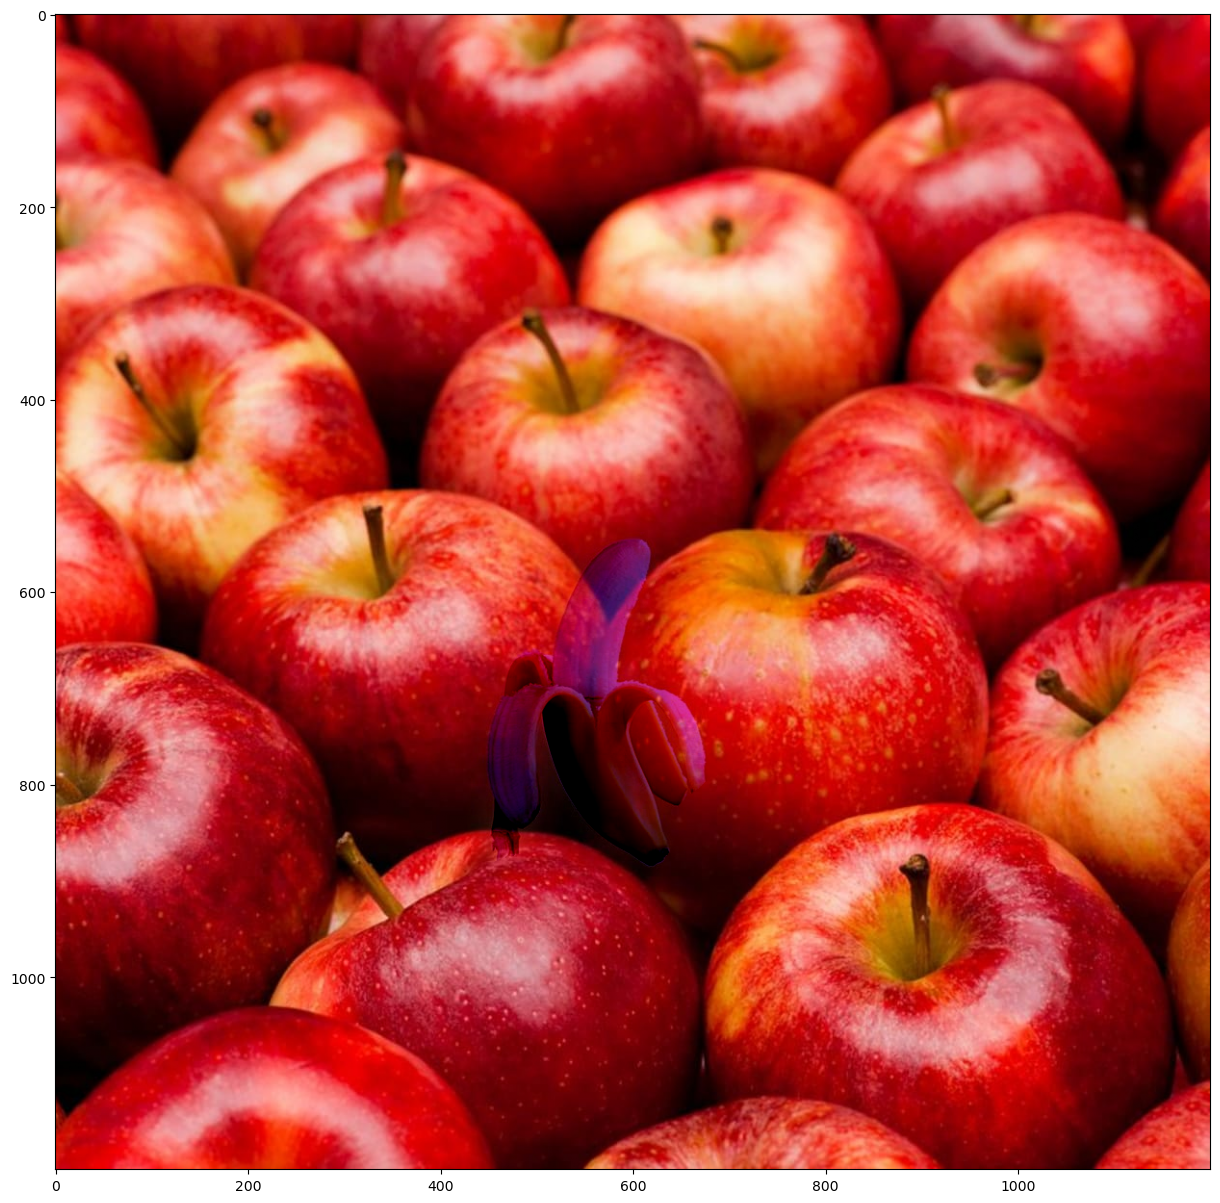

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(im_mix)